In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
import math

In [3]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [4]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        self.fc1 = nn.Linear(4, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def transformState(S_t):
    return [ math.atan2( S_t[0], S_t[1]), math.atan2( S_t[2], S_t[3]), S_t[4], S_t[5] ]

episode_durations = []
episode_rewards = []
episode_success = []

def main():

    # Parameters
    num_episode = 1000
    batch_size = 5
    learning_rate = 0.01
    gamma = 0.99

    env = gym.make('Acrobot-v1')
    policy_net = Actor()
    policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)

    state_net = Critic()
    state_optimizer = torch.optim.Adam(state_net.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    # Batch History
    state_pool = []
    action_pool = []
    reward_pool = []
    delta_pool = []
    value1_pool = []
    value2_pool =[]
    steps = 0


    for e in range(num_episode):

        state = env.reset()[0]
        state = np.array(transformState(state))
        state = torch.from_numpy(state).float()
        state = Variable(state)

        for t in range(1000):

            probs = policy_net(state)
            m = Categorical(probs)
            action = m.sample()

            value_1 = state_net(state)

            action = action.data.numpy().astype(int)
            stepData = env.step(action)
            next_state, reward, done, truncated, info = stepData[0], stepData[1], stepData[2], stepData[3], stepData[4]
            next_state = np.array(transformState(next_state))

            value_2 = state_net(torch.from_numpy(next_state).float())

            # To mark boundarys between episodes
            if done:
                # value_t = Variable(0)
                reward = 0

            state_pool.append(state)
            action_pool.append(float(action))
            reward_pool.append(reward)

            delta_pool.append(reward + gamma*float(value_2) - float(value_1))

            value1_pool.append(value_1)
            value2_pool.append(value_2)
            # print(value_1)

            state = next_state
            state = torch.from_numpy(state).float()
            state = Variable(state)

            steps += 1

            if done:
                episode_durations.append(t + 1)
                print("Episode:",e,"\tDuration:",t+1)
                episode_rewards.append(-t)

                break

        # Update policy
        if e > 0 and e % batch_size == 0:

            # running_delta = 0
            I = 1

            for i in reversed(range(steps)):
                if reward_pool[i] == 0:
                    # running_delta = 0
                    I = 1
                else:
                    # running_delta = running_delta + delta_pool[i]
                    delta_pool[i] = I*delta_pool[i]
                    I = gamma*I

            # Normalize delta
            # delta_mean = np.mean(delta_pool)
            # delta_std = np.std(delta_pool)
            # for i in range(steps):
            #     delta_pool[i] = (delta_pool[i] - delta_mean) / delta_std

            # Gradient Desent

            state_optimizer.zero_grad()
            for i in range(steps-1):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                delta = delta_pool[i]
                value1 = value1_pool[i]
                value2 = value2_pool[i]

                loss = reward + delta*value2 - value1 
                loss = Variable(loss, requires_grad=True)

                # probs = state_net(state)
                # m = Categorical(probs)
                # loss = m.probs * delta

                # print(loss)
                # print(loss)
                loss.backward()
            state_optimizer.step()



            policy_optimizer.zero_grad()
            for i in range(steps):
                state = state_pool[i]
                action = Variable(torch.FloatTensor([action_pool[i]]))
                delta = delta_pool[i]

                probs = policy_net(state)
                m = Categorical(probs)
                loss = -m.log_prob(action) * delta  # Negtive score function x reward
                loss.backward()
            policy_optimizer.step()

            
            state_pool = []
            action_pool = []
            reward_pool = []
            delta_pool = []
            steps = 0


if __name__ == '__main__':
    main()

/home/devraj/.pyenv/versions/3.10.4/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 10 	Duration: 763


KeyboardInterrupt: 

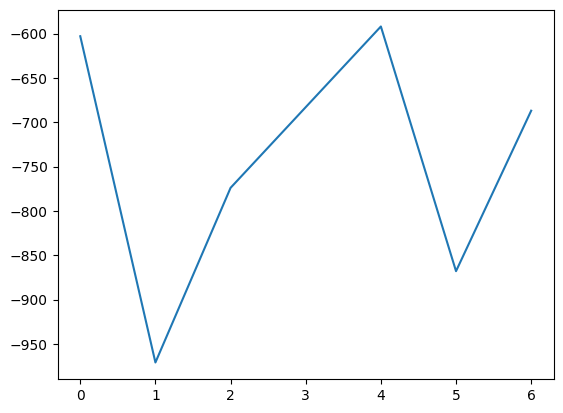

In [ ]:
plt.figure()
plt.plot(episode_rewards)
plt.show()